<a href="https://colab.research.google.com/github/nidhaloff/Beer-Consumption/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [865]:
import keras
from keras import backend as K
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score

%matplotlib inline

# run keras model on google GPU
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [866]:
dataset = pd.read_csv('/content/Consumo_cerveja.csv', thousands=',')
print(dataset.columns)
print(dataset.info())
print(dataset.describe())

Index(['Data', 'Temperatura Media (C)', 'Temperatura Minima (C)',
       'Temperatura Maxima (C)', 'Precipitacao (mm)', 'Final de Semana',
       'Consumo de cerveja (litros)'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941 entries, 0 to 940
Data columns (total 7 columns):
Data                           365 non-null object
Temperatura Media (C)          365 non-null float64
Temperatura Minima (C)         365 non-null float64
Temperatura Maxima (C)         365 non-null float64
Precipitacao (mm)              365 non-null float64
Final de Semana                365 non-null float64
Consumo de cerveja (litros)    365 non-null float64
dtypes: float64(6), object(1)
memory usage: 51.5+ KB
None
       Temperatura Media (C)  ...  Consumo de cerveja (litros)
count             365.000000  ...                   365.000000
mean             1700.153425  ...                    25.401367
std               834.669898  ...                     4.399143
min                14.0

In [0]:
dataset = dataset[:365]

In [868]:
dataset.tail(5)

,Data,Temperatura Media (C),Temperatura Minima (C),Temperatura Maxima (C),Precipitacao (mm),Final de Semana,Consumo de cerveja (litros)
360,2015-12-27,24.0,211.0,282.0,136.0,1.0,32.307
361,2015-12-28,2264.0,211.0,267.0,0.0,0.0,26.095
362,2015-12-29,2168.0,203.0,241.0,103.0,0.0,22.309
363,2015-12-30,2138.0,193.0,224.0,63.0,0.0,20.467
364,2015-12-31,2476.0,202.0,29.0,0.0,0.0,22.446


In [869]:
dataset.dtypes

Data                            object
Temperatura Media (C)          float64
Temperatura Minima (C)         float64
Temperatura Maxima (C)         float64
Precipitacao (mm)              float64
Final de Semana                float64
Consumo de cerveja (litros)    float64
dtype: object

In [0]:
# translate column names
dataset.columns = ('Date', 'MediumTemperature', 'MinTemperature', 'MaxTemperature', 'Precipitation', 'Weekend', 'Consumption')

In [871]:
dataset.head(5)

,Date,MediumTemperature,MinTemperature,MaxTemperature,Precipitation,Weekend,Consumption
0,2015-01-01,273.0,239.0,325.0,0.0,0.0,25.461
1,2015-01-02,2702.0,245.0,335.0,0.0,0.0,28.972
2,2015-01-03,2482.0,224.0,299.0,0.0,1.0,30.814
3,2015-01-04,2398.0,215.0,286.0,12.0,1.0,29.799
4,2015-01-05,2382.0,21.0,283.0,0.0,0.0,28.900


In [872]:
dataset.shape

(365, 7)

In [873]:
dataset.isna().sum()

Date                 0
MediumTemperature    0
MinTemperature       0
MaxTemperature       0
Precipitation        0
Weekend              0
Consumption          0
dtype: int64

In [0]:
# alright we have no missed values there
date_column = dataset.pop('Date')

In [875]:
date_column = pd.to_datetime(date_column)
date_column.head(5)

0   2015-01-01
1   2015-01-02
2   2015-01-03
3   2015-01-04
4   2015-01-05
Name: Date, dtype: datetime64[ns]

In [0]:
dataset['Day'] = date_column.dt.day

In [0]:
dataset['Month'] = date_column.dt.month
dataset['Year'] = date_column.dt.year

In [878]:
dataset.head(5)

,MediumTemperature,MinTemperature,MaxTemperature,Precipitation,Weekend,Consumption,Day,Month,Year
0,273.0,239.0,325.0,0.0,0.0,25.461,1,1,2015
1,2702.0,245.0,335.0,0.0,0.0,28.972,2,1,2015
2,2482.0,224.0,299.0,0.0,1.0,30.814,3,1,2015
3,2398.0,215.0,286.0,12.0,1.0,29.799,4,1,2015
4,2382.0,21.0,283.0,0.0,0.0,28.900,5,1,2015


In [879]:
dataset.shape

(365, 9)

In [0]:
def plot_correlation_matrix(data):
    plt.figure(figsize=(10, 10))
    top_features = data.corr().index
    color = plt.get_cmap('RdYlGn')
    color.set_bad('lightblue')
    sns.heatmap(data[top_features].corr(), annot=True, cmap=color)

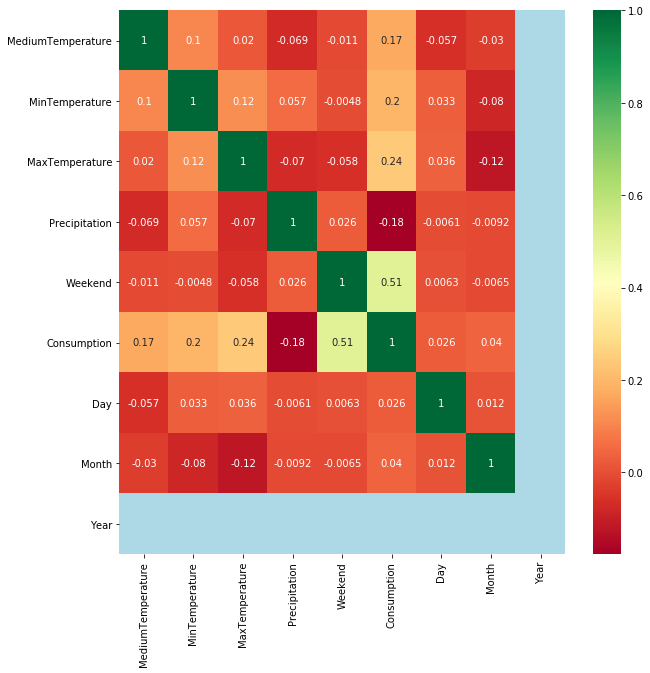

In [881]:
plot_correlation_matrix(dataset)

In [0]:
dataset.drop('Year', axis=1, inplace=True)

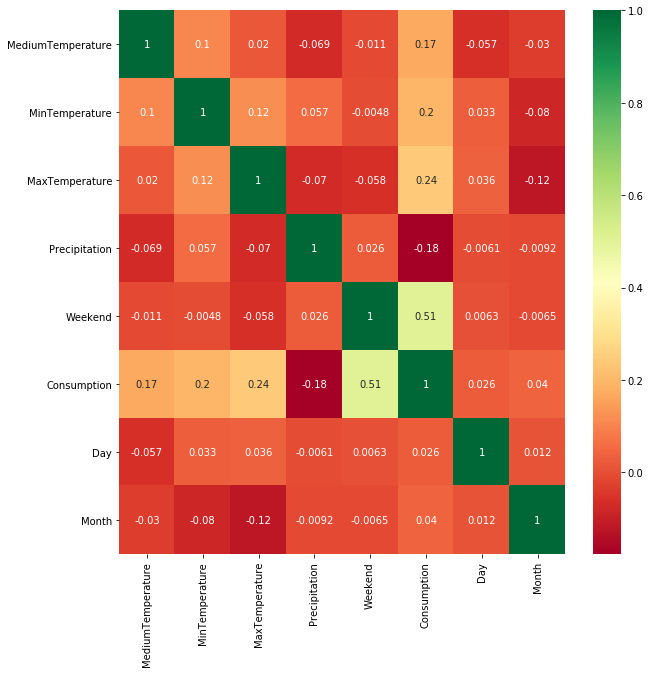

In [883]:
plot_correlation_matrix(dataset)

   MediumTemperature  MinTemperature  MaxTemperature  ...  Consumption  Day  Month
0              273.0           239.0           325.0  ...       25.461    1      1
1             2702.0           245.0           335.0  ...       28.972    2      1
2             2482.0           224.0           299.0  ...       30.814    3      1
3             2398.0           215.0           286.0  ...       29.799    4      1
4             2382.0            21.0           283.0  ...       28.900    5      1

[5 rows x 8 columns]


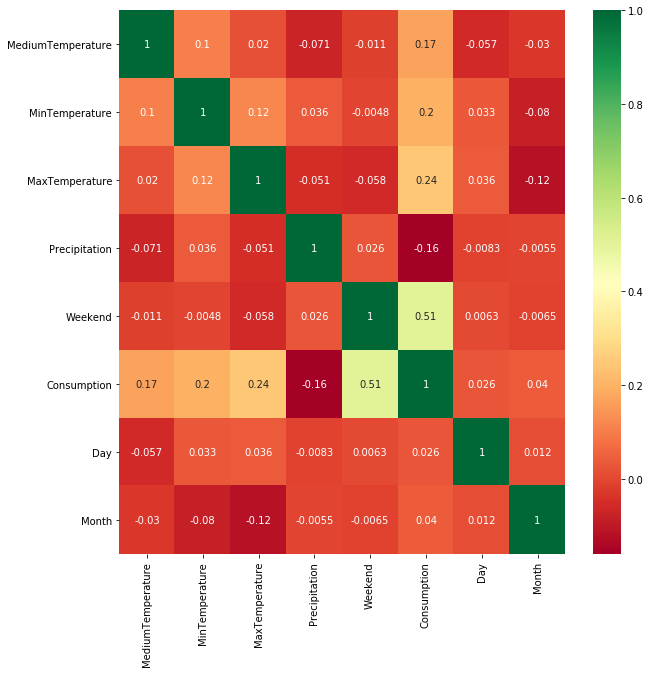

In [884]:
print(dataset.head(5))
dataset.Precipitation.replace(to_replace=0, value=dataset.Precipitation.mean(), inplace=True)

dataset.Precipitation = (dataset.Precipitation - dataset.Precipitation.mean()) / dataset.Precipitation.std()
dataset.MediumTemperature = (dataset.MediumTemperature - dataset.MediumTemperature.mean()) / dataset.MediumTemperature.std()
dataset.MinTemperature = (dataset.MinTemperature - dataset.MinTemperature.mean()) / dataset.MinTemperature.std()
dataset.MaxTemperature = (dataset.MaxTemperature - dataset.MaxTemperature.mean()) / dataset.MaxTemperature.std()
dataset.Day = (dataset.Day - dataset.Day.mean()) / dataset.Day.std()
dataset.Month = (dataset.Month - dataset.Month.mean()) / dataset.Month.std()
# dataset.Consumption = (dataset.Consumption - dataset.Consumption.mean()) / dataset.Consumption.std()
dataset.head(5)
plot_correlation_matrix(dataset)

In [885]:
y = dataset.pop('Consumption')
X = dataset

X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

X, y = X.to_numpy().astype(np.float32), y.to_numpy().astype(np.float32)

y = y.reshape(-1, 1)
print(np.any(np.isnan(X)))
print(X.shape, y.shape, type(X), type(y))

False
(365, 7) (365, 1) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [0]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)


In [0]:
trainset = TensorDataset(X, y)
loader = DataLoader(trainset, batch_size=32, shuffle=True)

In [0]:
class Net(nn.Module):
    def __init__(self, n_features=7, n_out=1):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 20)
        self.fc2 = nn.Linear(20, n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.fc2(out)
        return out

In [889]:
model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss(size_average=True)

def training_func(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        out = model(x)
        # Computes loss
        loss = loss_fn(out, y)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [0]:
train = training_func(model, criterion, optimizer)

def fit(epochs=100):
    losses, iters= [], []
    count = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train(x, y)
            count += 1
            if count % 50 == 0:
                losses.append(loss)
                iters.append(count)

    return losses, iters


[6.363826751708984, 4.323223114013672, 4.746865749359131, 3.8578054904937744]
[50, 100, 150, 200, 250]


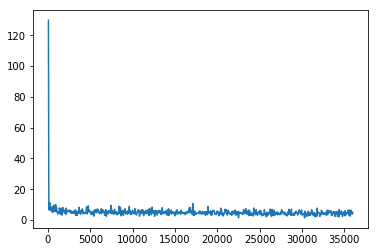

In [891]:
losses, iters = fit(3000)
print(losses[-5:-1])
print(iters[:5])
plt.plot(iters, losses)
plt.show()


In [892]:
def test():
    model.eval()
    
    losses = []
    count = 0
    with torch.no_grad():
        
        for X_test, y_test in loader:
            
            out = model(X_test)
            loss = criterion(out, y_test)
            losses.append(loss)
    return losses

val_losses = test()
print(val_losses)
print("average loss: ", sum(val_losses) / len(val_losses))


[tensor(4.0596), tensor(3.7867), tensor(4.5240), tensor(7.2282), tensor(2.8870), tensor(6.4880), tensor(4.4689), tensor(3.4739), tensor(5.0204), tensor(3.1979), tensor(3.9248), tensor(2.4349)]
average loss:  tensor(4.2912)


(365, 1) (365, 1) (365, 1) (365, 1)


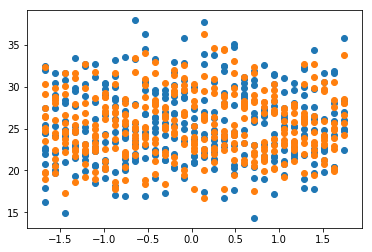

In [893]:
predictions = model(X)
targets = y
x_ax = np.arange(0, len(y)).reshape(-1, 1)
targets = targets.detach().numpy()
predictions = predictions.detach().numpy()
day_feature = dataset.Day.to_numpy().reshape(-1, 1)
print(x_ax.shape, targets.shape, predictions.shape, day_feature.shape)

plt.scatter(day_feature, targets, cmap='b')
plt.scatter(day_feature, predictions, cmap='r')
plt.show()


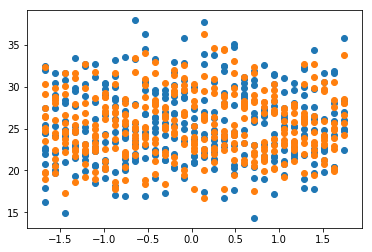

In [894]:

# get param values
state = model.state_dict()

plt.scatter(day_feature, targets, cmap='b')
plt.scatter(day_feature, predictions, cmap='r')

plt.show()

(20, 7) (1, 20) (1, 20) (1, 1)
Index(['MediumTemperature', 'MinTemperature', 'MaxTemperature',
       'Precipitation', 'Weekend', 'Day', 'Month'],
      dtype='object')
(20, 1)
(365, 1)


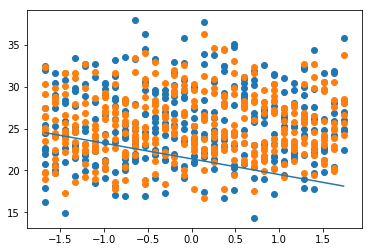

In [898]:

# w1, b1, w2, b2 = model.parameters()

# w1 = w1.detach().numpy()
# w2 = w2.detach().numpy()
# b1 = b1.detach().numpy().reshape(1, -1)
# b2 = b2.detach().numpy().reshape(-1, 1)
# print(w1.shape, w2.shape, b1.shape, b2.shape)
# print(dataset.columns)

# day_feature_weight = w1[:,5].reshape(-1, 1)
# print(day_feature_weight.shape)
# fit_line = (day_feature@day_feature_weight.T + b1)@w2.T + b2    # ((356, 1)@(1, 20) + b1) @ (20, 1) + b2 
# print(fit_line.shape) 
# plt.scatter(day_feature, targets, cmap='b')
# plt.scatter(day_feature, predictions, cmap='r')
# plt.plot(day_feature, fit_line)
# plt.show()

